Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Optimized Accuracy: 0.50

Confusion Matrix:
 [[945 454 439]
 [462 893 483]
 [467 478 893]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.51      0.51      1838
           1       0.49      0.49      0.49      1838
           2       0.49      0.49      0.49      1838

    accuracy                           0.50      5514
   macro avg       0.50      0.50      0.50      5514
weighted avg       0.50      0.50      0.50      5514



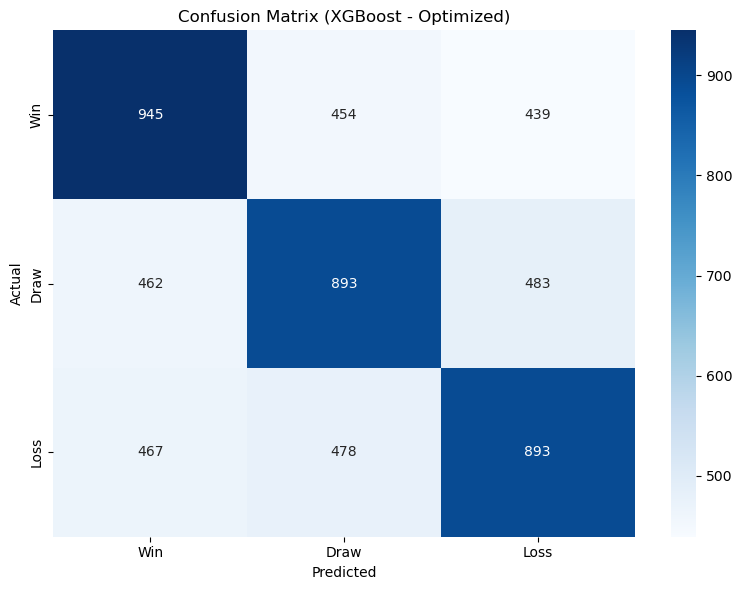

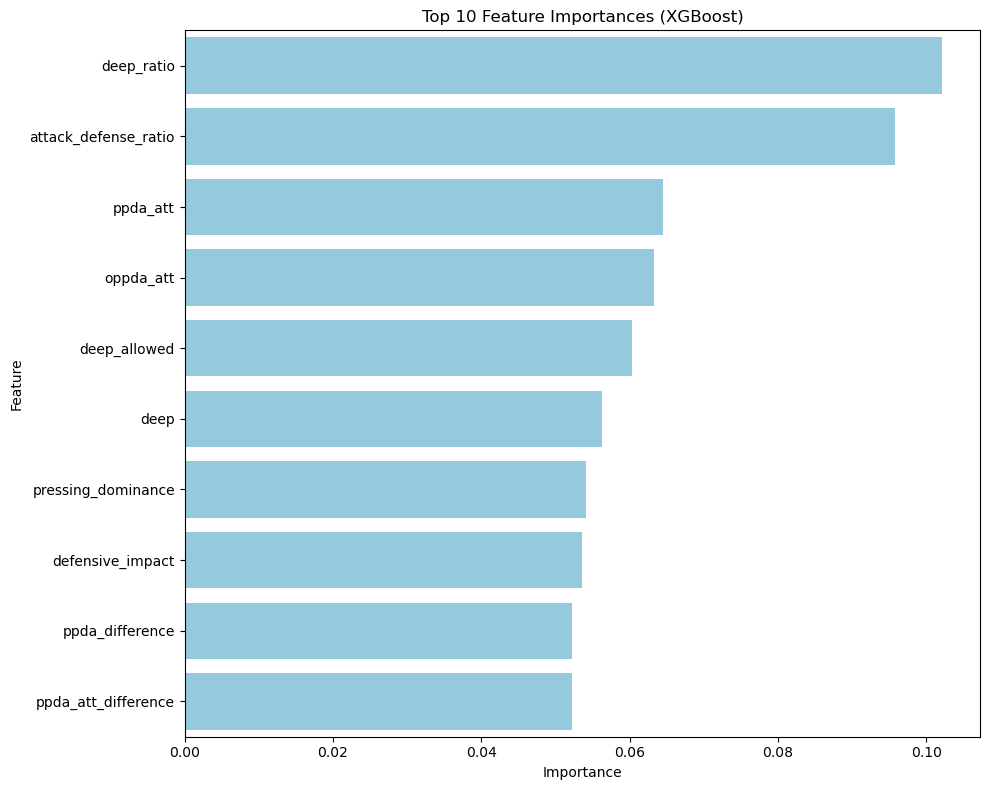

Feature Importances:

                   Feature  Importance
8               deep_ratio    0.102139
14    attack_defense_ratio    0.095809
4                 ppda_att    0.064511
6                oppda_att    0.063309
3             deep_allowed    0.060247
2                     deep    0.056255
15      pressing_dominance    0.054145
13        defensive_impact    0.053527
10         ppda_difference    0.052257
11     ppda_att_difference    0.052157
16     ppda_to_oppda_ratio    0.051907
5                 ppda_def    0.051618
12  pressing_effectiveness    0.051563
0                ppda_coef    0.049680
1               oppda_coef    0.048725
9               ppda_ratio    0.048251
7                oppda_def    0.043901


In [2]:
# Import necessary libraries
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and prepare the dataset
file_path = "understat_per_game.csv"  # Replace with your dataset path
dataset = pd.read_csv(file_path)

# Define tactical features and engineered features
tactical_features = [
    'ppda_coef', 'oppda_coef', 'deep', 'deep_allowed', 
    'ppda_att', 'ppda_def', 'oppda_att', 'oppda_def'
]
target_variable = 'result'

# Encode target variable
result_mapping = {'w': 0, 'd': 1, 'l': 2}  # Adjusted to 0, 1, 2 for XGBoost compatibility
dataset['result'] = dataset['result'].map(result_mapping)
dataset = dataset.dropna()

# Step 2: Feature Engineering
dataset['deep_ratio'] = dataset['deep'] / (dataset['deep_allowed'] + 1)  # Avoid division by zero
dataset['ppda_ratio'] = dataset['ppda_coef'] / (dataset['oppda_coef'] + 1)
dataset['ppda_difference'] = dataset['ppda_coef'] - dataset['oppda_coef']
dataset['ppda_att_difference'] = dataset['ppda_att'] - dataset['oppda_att']

dataset['pressing_effectiveness'] = dataset['ppda_coef'] * dataset['deep']
dataset['defensive_impact'] = dataset['ppda_def'] * dataset['deep_allowed']
dataset['attack_defense_ratio'] = dataset['deep'] / (dataset['deep_allowed'] + 1)
dataset['pressing_dominance'] = dataset['ppda_coef'] - dataset['oppda_coef']
dataset['ppda_to_oppda_ratio'] = dataset['ppda_coef'] / (dataset['oppda_coef'] + 1)

# Combine all features
features = tactical_features + [
    'deep_ratio', 'ppda_ratio', 'ppda_difference', 'ppda_att_difference',
    'pressing_effectiveness', 'defensive_impact', 'attack_defense_ratio',
    'pressing_dominance', 'ppda_to_oppda_ratio'
]

X = dataset[features]
y = dataset['result']

# Step 3: Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Step 5: Initialize XGBoost Classifier and Perform Grid Search with 5-Fold CV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss'  # Specify evaluation metric to handle the warning
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # Adjusted to 5-fold cross-validation
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Step 6: Evaluate the Optimized Model
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

y_pred = best_xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Best Parameters:", best_params)
print(f"Optimized Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Step 7: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Win', 'Draw', 'Loss'], yticklabels=['Win', 'Draw', 'Loss'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost - Optimized)')
plt.tight_layout()
plt.show()

# Step 8: Feature Importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature',  color='skyblue')  # Top 10 features
plt.title('Top 10 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("Feature Importances:\n")
print(feature_importance)



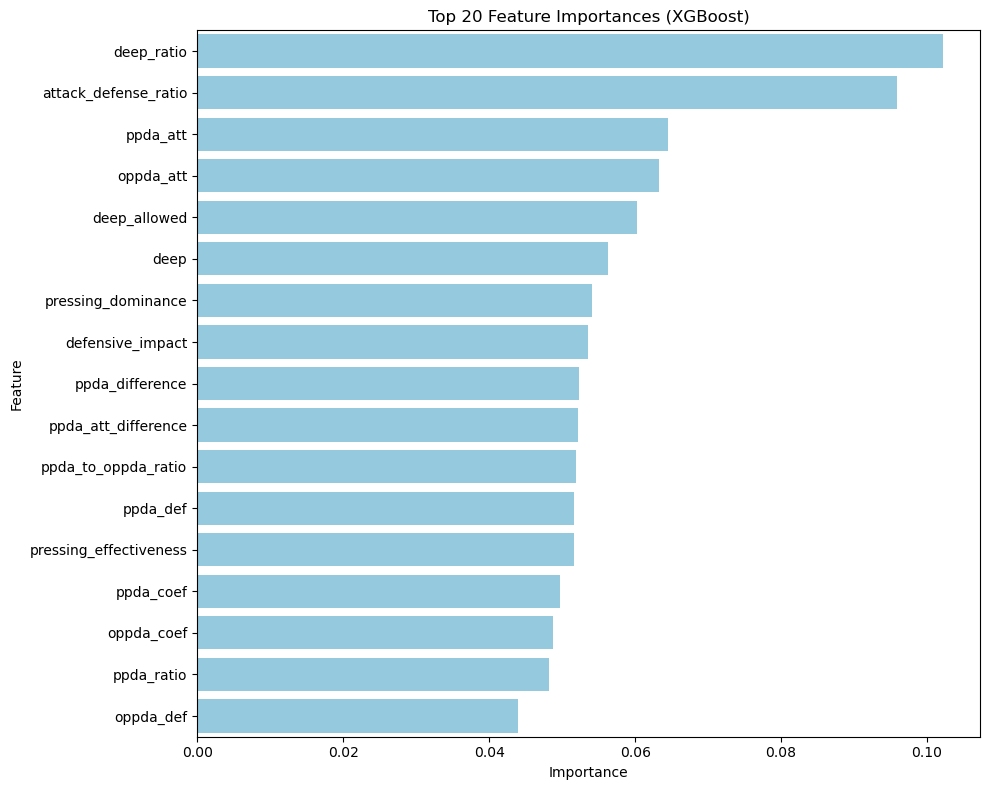

Feature Importances:

                   Feature  Importance
8               deep_ratio    0.102139
14    attack_defense_ratio    0.095809
4                 ppda_att    0.064511
6                oppda_att    0.063309
3             deep_allowed    0.060247
2                     deep    0.056255
15      pressing_dominance    0.054145
13        defensive_impact    0.053527
10         ppda_difference    0.052257
11     ppda_att_difference    0.052157
16     ppda_to_oppda_ratio    0.051907
5                 ppda_def    0.051618
12  pressing_effectiveness    0.051563
0                ppda_coef    0.049680
1               oppda_coef    0.048725
9               ppda_ratio    0.048251
7                oppda_def    0.043901


In [3]:
# Step 8: Feature Importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot Top 20 Feature Importances
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(20), x='Importance', y='Feature', color='skyblue')  # Top 20 features
plt.title('Top 20 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("Feature Importances:\n")
print(feature_importance)

In [6]:
feature_importance.to_csv('xgboost_feature_importances.csv', index=False)